In [2]:
from patsy import dmatrices
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import math
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import cleaning

In [3]:
df = cleaning.df
df.columns

Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score',
       'gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability', 'num_of_prev_attempts', 'studied_credits', 'code_module',
       'code_presentation', 'assessment_type', 'date', 'weight',
       'sum_clicksum_dataplus', 'sum_clicksum_dualpane',
       'sum_clicksum_externalquiz', 'sum_clicksum_folder',
       'sum_clicksum_forumng', 'sum_clicksum_glossary',
       'sum_clicksum_homepage', 'sum_clicksum_htmlactivity',
       'sum_clicksum_oucollaborate', 'sum_clicksum_oucontent',
       'sum_clicksum_ouelluminate', 'sum_clicksum_ouwiki', 'sum_clicksum_page',
       'sum_clicksum_questionnaire', 'sum_clicksum_quiz',
       'sum_clicksum_repeatactivity', 'sum_clicksum_resource',
       'sum_clicksum_sharedsubpage', 'sum_clicksum_subpage',
       'sum_clicksum_url', 'x0_F', 'x0_M', 'x0_East_Anglian_Region',
       'x0_East_Midlands_Region', 'x0_Ireland', 'x0_London_Region',
       'x0_

### Question: how much do student traits impact the score?
Omitting GGG and BBB tests with CMA grading because they have such an odd distribution. Initial EDA showed this- see Rmd report.


In [4]:
df = df.query('x0_GGG + x0_CMA < 2 & x0_BBB + x0_CMA < 2')


## General EDA

In [5]:
pd.crosstab(df['imd_band'], df['age_band'], normalize='index')


age_band,0-35,35-55,55<=
imd_band,,,
0-10%,0.754247,0.245753,0.000000
10-20,0.740423,0.258522,0.001055
20-30%,0.728926,0.267863,0.003212
30-40%,0.699866,0.295733,0.004401
40-50%,0.701256,0.295746,0.002998
50-60%,0.693655,0.295066,0.011278
60-70%,0.685820,0.304428,0.009752
70-80%,0.663733,0.327016,0.009252
80-90%,0.685004,0.302896,0.012100


Older students may be a bit better off economically.

In [6]:
pd.crosstab(df['imd_band'], df['gender'], normalize='index')


gender,F,M
imd_band,,
0-10%,0.446206,0.553794
10-20,0.430210,0.569790
20-30%,0.426459,0.573541
30-40%,0.373162,0.626838
40-50%,0.406531,0.593469
50-60%,0.393737,0.606263
60-70%,0.377504,0.622496
70-80%,0.362801,0.637199
80-90%,0.351759,0.648241


Somewhat higher proportions of male students at higher deprivation end. 

In [7]:
pd.crosstab(df['x0_F'], df['age_band'], normalize='index')


age_band,0-35,35-55,55<=
x0_F,,,
0.0,0.704025,0.284879,0.011096
1.0,0.683623,0.313472,0.002904


In [8]:
pd.crosstab(df['region'], df['gender'], normalize='index')


gender,F,M
region,,
East Anglian Region,0.399037,0.600963
East Midlands Region,0.410366,0.589634
Ireland,0.343939,0.656061
London Region,0.394393,0.605607
North Region,0.288766,0.711234
North Western Region,0.342391,0.657609
Scotland,0.374051,0.625949
South East Region,0.417946,0.582054
South Region,0.354191,0.645809


Higher proportion of male students in North, no indication it's a major issue though.

## Correlations

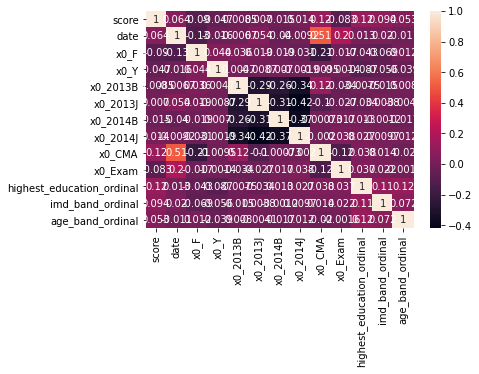

In [9]:
feature_list = ['score', 'date',
                'x0_F', 'x0_Y', 'x0_2013B', 'x0_2013J', 'x0_2014B', 'x0_2014J', 'x0_CMA',
                'x0_Exam', 'highest_education_ordinal', 'imd_band_ordinal', 'age_band_ordinal']

corrMatrix = df[feature_list].corr()
sn.heatmap(corrMatrix, annot=True)


Female students less likely to have computer marked exams. Final exam scores are lower than the exams during the term. Hard to draw many conclusions from this because there are so many interacting factors.

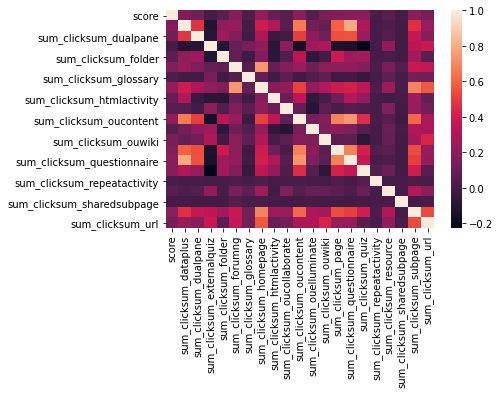

In [10]:
feature_list = ['score', 'sum_clicksum_dataplus', 'sum_clicksum_dualpane',
                'sum_clicksum_externalquiz', 'sum_clicksum_folder',
                'sum_clicksum_forumng', 'sum_clicksum_glossary',
                'sum_clicksum_homepage', 'sum_clicksum_htmlactivity',
                'sum_clicksum_oucollaborate', 'sum_clicksum_oucontent',
                'sum_clicksum_ouelluminate', 'sum_clicksum_ouwiki', 'sum_clicksum_page',
                'sum_clicksum_questionnaire', 'sum_clicksum_quiz',
                'sum_clicksum_repeatactivity', 'sum_clicksum_resource',
                'sum_clicksum_sharedsubpage', 'sum_clicksum_subpage',
                'sum_clicksum_url']

corrMatrix = df[feature_list].corr()
sn.heatmap(corrMatrix, annot=False)


Clicks to homepage seem pretty correlated to higher scores - eg, getting on the site at all is a good sign?

In [11]:

feature_list = ['score', 'date',
                'x0_F', 'x0_Y', 'x0_AAA', 'x0_BBB', 'x0_CCC', 'x0_DDD', 'x0_EEE', 'x0_FFF', 'x0_GGG',
                'x0_Exam', 'highest_education_ordinal', 'imd_band_ordinal', 'age_band_ordinal']


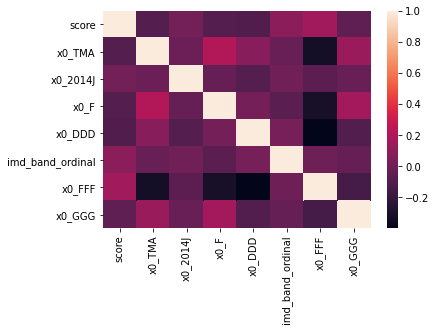

In [12]:


feature_list = ['score','x0_TMA', 'x0_2014J', 'x0_F',
                'x0_DDD', 'imd_band_ordinal', 'x0_FFF', 'x0_GGG']

corrMatrix = df[feature_list].corr()
sn.heatmap(corrMatrix, annot=False)

Module FFF has higher scores, higher SES correlates to higher scores.

## T-tests for groups

### Gender 

In [14]:
stats.ttest_ind(df.query('x0_F == 0.0')['score'].to_numpy(), df.query(
    'x0_F == 1.0')['score'].to_numpy(), nan_policy="omit")


Ttest_indResult(statistic=36.63377985309357, pvalue=1.2811585581008678e-292)

### Disability

In [15]:
stats.ttest_ind(df.query('x0_Y == 0.0')['score'].to_numpy(), df.query(
    'x0_Y == 1.0')['score'].to_numpy(), nan_policy="omit")


Ttest_indResult(statistic=18.90129834859468, pvalue=1.353154903112074e-79)

### CMA

In [16]:

stats.ttest_ind(df.query('x0_CMA == 0.0')['score'].to_numpy(), df.query(
    'x0_CMA == 1.0')['score'].to_numpy(), nan_policy="omit")


Ttest_indResult(statistic=-50.371994454947774, pvalue=0.0)

### Final exam

In [17]:

stats.ttest_ind(df.query('x0_Exam == 0.0')['score'].to_numpy(), df.query(
    'x0_Exam == 1.0')['score'].to_numpy(), nan_policy="omit")


Ttest_indResult(statistic=33.511300847687984, pvalue=2.2482494974722814e-245)

### Prior Education

In [18]:

# Prior education high
stats.ttest_ind(df.query('highest_education_ordinal > 3')['score'].to_numpy(), df.query(
    'highest_education_ordinal <= 3')['score'].to_numpy(), nan_policy="omit")


Ttest_indResult(statistic=36.84525257205809, pvalue=5.734407704083419e-296)

## Modeling

In [19]:
feature_list = ['score','x0_F', 'num_of_prev_attempts', 'studied_credits', 'x0_East_Anglian_Region','x0_East_Midlands_Region', 'x0_Ireland', 'x0_London_Region', 'x0_North_Region', 'x0_North_Western_Region', 'x0_Scotland','x0_South_East_Region', 'x0_South_Region', 'x0_South_West_Region', 'x0_Wales', 'x0_West_Midlands_Region', 'x0_Yorkshire_Region', 'x0_N', 'x0_AAA', 'x0_BBB', 'x0_CCC', 'x0_EEE','x0_DDD', 'x0_FFF', 'x0_GGG','x0_2013B', 'x0_2013J', 'x0_2014B', 'x0_2014J', 'x0_CMA', 'x0_Exam', 'highest_education_ordinal', 'imd_band_ordinal', 'age_band_ordinal', 'date','sum_clicksum_dataplus', 'sum_clicksum_dualpane','sum_clicksum_externalquiz', 'sum_clicksum_folder','sum_clicksum_forumng', 'sum_clicksum_glossary','sum_clicksum_homepage', 'sum_clicksum_htmlactivity','sum_clicksum_oucollaborate', 'sum_clicksum_oucontent','sum_clicksum_ouelluminate', 'sum_clicksum_ouwiki', 'sum_clicksum_page','sum_clicksum_questionnaire', 'sum_clicksum_quiz','sum_clicksum_repeatactivity', 'sum_clicksum_resource','sum_clicksum_sharedsubpage', 'sum_clicksum_subpage','sum_clicksum_url']

In [20]:
# Split and CV with gridsearch
# NOTE: this takes time because of the 5-fold cv alongside a gridsearch, go in to cleaning.py if you want to turn off the gridsearch or reduce the folds.

dtrain, dtest, cv_results, X_train, X_test, y_train, y_test = cleaning.cv_model(
    dataframe=df, feature_list=feature_list)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.777598,0.270886,0.050113,0.002444,0.01,6,"{'eta': 0.01, 'max_depth': 6}",-3.086275,-1.764029,-2.335651,-1.172623,-2.360043,-2.143724,0.641753,3
1,10.207389,0.355553,0.068357,0.002174,0.01,8,"{'eta': 0.01, 'max_depth': 8}",-3.122651,-1.871632,-2.303461,-1.164242,-2.369600,-2.166317,0.642760,4
2,7.448555,0.083473,0.058617,0.003363,0.05,6,"{'eta': 0.05, 'max_depth': 6}",0.178202,0.032135,0.226941,0.187655,0.112599,0.147506,0.068400,1
3,10.643541,0.715320,0.073202,0.007871,0.05,8,"{'eta': 0.05, 'max_depth': 8}",0.195458,-0.011287,0.227667,0.201340,0.119871,0.146610,0.086716,2


In normal circumstances, I would try to run a broader gridsearch.

In [21]:
# Train and predict, use params chosen above
modelobj = cleaning.train_model(dtrain, dtest, eta=0.05, max_depth = 6)

preds_y, preds_train, train_residuals, test_residuals = cleaning.predict_eval(
    dtrain, dtest, y_train, y_test, modelobj)


[0]	eval-rmse:71.53770	train-rmse:71.61233
[1]	eval-rmse:68.16344	train-rmse:68.23348
[2]	eval-rmse:64.96679	train-rmse:65.03413
[3]	eval-rmse:61.93977	train-rmse:62.00288
[4]	eval-rmse:59.07279	train-rmse:59.13299
[5]	eval-rmse:56.36047	train-rmse:56.41694
[6]	eval-rmse:53.79408	train-rmse:53.84821
[7]	eval-rmse:51.36912	train-rmse:51.41852
[8]	eval-rmse:49.07735	train-rmse:49.12348
[9]	eval-rmse:46.91383	train-rmse:46.95460
[10]	eval-rmse:44.86870	train-rmse:44.90592
[11]	eval-rmse:42.94119	train-rmse:42.97382
[12]	eval-rmse:41.11928	train-rmse:41.14726
[13]	eval-rmse:39.40360	train-rmse:39.42736
[14]	eval-rmse:37.78471	train-rmse:37.80405
[15]	eval-rmse:36.26265	train-rmse:36.27792
[16]	eval-rmse:34.83012	train-rmse:34.84034
[17]	eval-rmse:33.48414	train-rmse:33.48965
[18]	eval-rmse:32.22133	train-rmse:32.22131
[19]	eval-rmse:31.03502	train-rmse:31.03096
[20]	eval-rmse:29.92600	train-rmse:29.91584
[21]	eval-rmse:28.88681	train-rmse:28.87147
[22]	eval-rmse:27.91571	train-rmse:27.8952

In [22]:
result_train = pd.DataFrame(X_train, columns=feature_list[1:])
result_test = pd.DataFrame(X_test, columns=feature_list[1:])

result_train['predictions'] = preds_train
result_test['predictions'] = preds_y
result_train['truth'] = y_train
result_test['truth'] = y_test
result_train['residual'] = train_residuals
result_test['residual'] = test_residuals

In [23]:
print("Mean Train Residual: " + str(result_train.residual.mean()))
print("StDev Train Residual: " + str(result_train.residual.std()))
print("Median Train Residual: " + str(result_train.residual.median()))

print("Mean Test Residual: " + str(result_test.residual.mean()))
print("StDev Test Residual: " + str(result_test.residual.std()))
print("Median Test Residual: " + str(result_test.residual.median()))

print("Total Y Mean: " + str(df.score.mean()))
print("Total Y StDev: " + str(df.score.std()))
print("Total Y Median: " + str(df.score.median()))

print("Train MSE: " + str(mean_squared_error(y_train, preds_train)))
print("Test MSE: " + str(mean_squared_error(y_test, preds_y)))

print("Train MAE: " + str(mean_absolute_error(y_train, preds_train)))
print("Test MAE: " + str(mean_absolute_error(y_test, preds_y)))


Mean Train Residual: 10.923665408307945
StDev Train Residual: 9.66691516474285
Median Train Residual: 8.593124389648438
Mean Test Residual: 11.287407196381762
StDev Test Residual: 10.092636110403955
Median Test Residual: 8.8148193359375
Total Y Mean: 73.49289258619532
Total Y StDev: 18.489463445475764
Total Y Median: 77.0
Train MSE: 212.77484024514197
Test MSE: 229.26464073090514
Train MAE: 10.923665408307945
Test MAE: 11.287407196381762


In [24]:

result_test.to_csv("../data/clean/preds_test_m1.csv")
result_train.to_csv("../data/clean/preds_train_m1.csv")

In [25]:
# Feature importance
gainfeat = modelobj.get_score(importance_type='gain')
sorted(gainfeat, key=gainfeat.get, reverse=True)[1:10]




['x0_EEE',
 'x0_CCC',
 'sum_clicksum_quiz',
 'x0_DDD',
 'sum_clicksum_dataplus',
 'highest_education_ordinal',
 'sum_clicksum_ouwiki',
 'x0_FFF',
 'sum_clicksum_forumng']

Visiting homepage often is a key predictor, also some types of course, then other content consumption, then past education. Good to see that academic behavior outweighs student characteristics for the most part.

## LM comparisons
To see just what we get from a plain old regression, to compare to the xgb, we can test.


In [26]:

# add student traits .154 R2
y, X = dmatrices('score ~ gender + disability + num_of_prev_attempts + studied_credits + date + date_submitted + region + code_module + code_presentation + assessment_type+ highest_education_ordinal+imd_band_ordinal+age_band_ordinal+sum_clicksum_dataplus + sum_clicksum_dualpane + sum_clicksum_externalquiz + sum_clicksum_folder + sum_clicksum_forumng + sum_clicksum_glossary + sum_clicksum_homepage + sum_clicksum_htmlactivity + sum_clicksum_oucollaborate + sum_clicksum_oucontent + sum_clicksum_ouelluminate + sum_clicksum_ouwiki + sum_clicksum_page + sum_clicksum_questionnaire + sum_clicksum_quiz + sum_clicksum_repeatactivity + sum_clicksum_resource + sum_clicksum_sharedsubpage + sum_clicksum_subpage + sum_clicksum_url + code_module*code_presentation + code_module*assessment_type + code_presentation*assessment_type', data=df, return_type='dataframe')

est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     402.0
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:29:40   Log-Likelihood:            -6.4823e+05
No. Observations:              152657   AIC:                         1.297e+06
Df Residuals:                  152585   BIC:                         1.297e+06
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------


Overall R^2 is not impressive, but it gives another angle on the feature importances.

In [27]:

preds_y2 = est2.predict(X)
X['preds'] = preds_y2
X['truth'] = y
X['residuals'] = np.absolute(X['truth'] - X['preds'])


In [28]:
print("Mean Train Residual: " + str(X.residuals.mean()))
print("StDev Train Residual: " + str(X.residuals.std()))
print("Median Train Residual: " + str(X.residuals.median()))

print("Total Y Mean: " + str(X.truth.mean()))
print("Total Y StDev: " + str(X.truth.std()))
print("Total Y Median: " + str(X.truth.median()))

print("Train MSE: " + str(mean_squared_error(X['truth'], X['preds'])))

print("Train MAE: " + str(mean_absolute_error(X['truth'], X['preds'])))

Mean Train Residual: 12.793458176297378
StDev Train Residual: 11.04483295758724
Median Train Residual: 10.319746141905497
Total Y Mean: 73.36416934696739
Total Y StDev: 18.414421566736735
Total Y Median: 77.0
Train MSE: 285.66010806884765
Train MAE: 12.793458176297378


Compared to the MSE/MAE of the xgboost approach, this is markedly worse, as we would expect.